In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
1.14.0


In [44]:
IMAGE_SIZE = [180, 180]

train_path = 'Images/train'
valid_path = 'Images/validation'
test_path = 'Images/test'


Using weights from imagenet for VGG 16 model 

In [45]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [46]:
folders = glob('Images/train/*/*')

In [47]:
COUNT_BIRD = len([filename for filename in folders if "bird" in filename])
print("bird images count in training set: " + str(COUNT_BIRD))

COUNT_CAT = len([filename for filename in train_filenames if "cat" in filename])
print("cat images count in training set: " + str(COUNT_CAT))

COUNT_DOG = len([filename for filename in folders if "dog" in filename])
print("Normal images count in training set: " + str(COUNT_DOG))

COUNT_HORSE = len([filename for filename in train_filenames if "horse" in filename])
print("Pneumonia images count in training set: " + str(COUNT_HORSE))

bird images count in training set: 3750
cat images count in training set: 2982
Normal images count in training set: 3750
Pneumonia images count in training set: 3021


The dataset is balanced so no data Argumentation needed.

In [5]:
  
# our layers - you can add more if you want
x = Flatten()(vgg.output)
#x = Dense(1000, activation='relu')(x)
#Final prediction will have 2 output prediction as len(folder) is 4
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

I will be using Sequential method as I am creating a sequential model. Sequential model means that all the layers of the model will be arranged in sequence. Here I have imported ImageDataGenerator from keras.preprocessing. The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this class is that it doesn’t affect the data stored on the disk. This class alters the data on the go while passing it to the model.

In [7]:
#Model training and creation

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('Images/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('Images/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_vgg16.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


# fit the model
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Found 15000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
469/469 [==============================] - 1291s 3s/step - loss: 0.9508 - acc: 0.6025 - val_loss: 0.7984 - val_acc: 0.6700
Epoch 2/5
469/469 [==============================] - 1473s 3s/step - loss: 0.8109 - acc: 0.6732 - val_loss: 0.8855 - val_acc: 0.6355
Epoch 3/5
469/469 [==============================] - 1264s 3s/step - loss: 0.7520 - acc: 0.6933 - val_loss: 0.7486 - val_acc: 0.6990
Epoch 4/5
469/469 [==============================] - 1265s 3s/step - loss: 0.7110 - acc: 0.7177 - val_loss: 0.8789 - val_acc: 0.6375
Epoch 5/5
469/469 [==============================] - 1267s 3s/step - loss: 0.7105 - acc: 0.7152 - val_loss: 0.7206 - val_acc: 0.7095


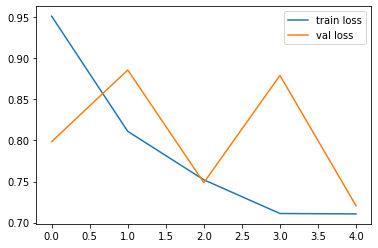

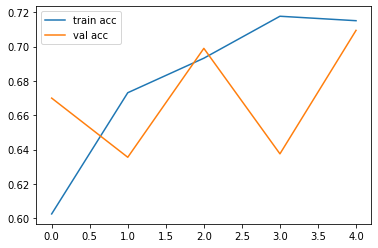

<Figure size 432x288 with 0 Axes>

In [8]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [9]:
#saving the model created
import tensorflow as tf
from keras.models import load_model
model.save('model_vgg16.h5')
